In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class MACDBacktester(): 
    
    def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.signal_mw = signal_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "MACDBacktester(symbol = {}, MACD({}, {}, {}), start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
        raw["MACD"] = raw.EMA_S - raw.EMA_L
        raw["MACD_Signal"] = raw.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean() 
        self.data = raw
      
        
    def set_parameters(self, EMA_S = None, EMA_L = None, signal_mw = None):
        ''' Updates MACD parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if signal_mw is not None:
            self.signal_mw = signal_mw
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["MACD"] > data["MACD_Signal"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | MACD ({}, {}, {}) | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, MACD):
        ''' Updates MACD parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(MACD[0]), int(MACD[1]), int(MACD[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA_S_range, EMA_L_range, signal_mw_range):
        ''' Finds global maximum given the MACD parameter ranges.
        '''
        opt = brute(self.update_and_run, (EMA_S_range, EMA_L_range, signal_mw_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = MACDBacktester("Nifty50", EMA_S = 12, EMA_L = 26, signal_mw = 9, start = "2008-01-01", end = "2022-07-01", tc = 0.0004)

In [4]:
tester

MACDBacktester(symbol = Nifty50, MACD(12, 26, 9), start = 2008-01-01, end = 2022-07-01)

In [5]:
tester.test_strategy()

(1.356902, -1.618876)

In [6]:
tester.results

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2008-02-18,5276.899902,-0.004915,5187.792150,5301.723541,-113.931391,-140.837848,1,-0.004915,0.0,0.995097,0.995097
2008-02-19,5280.799805,0.000739,5202.136083,5300.070088,-97.934005,-131.450732,1,0.000739,0.0,0.995832,0.995832
2008-02-20,5154.450195,-0.024217,5194.784587,5288.619456,-93.834869,-123.372423,1,-0.024217,0.0,0.972006,0.972006
2008-02-21,5191.799805,0.007220,5194.324585,5281.040725,-86.716140,-115.614680,1,0.007220,0.0,0.979049,0.979049
2008-02-22,5110.750000,-0.015734,5181.447887,5267.766700,-86.318813,-109.485962,1,-0.015734,0.0,0.963765,0.963765
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,15699.250000,0.009125,15705.503943,15966.456857,-260.952914,-237.653894,-1,-0.009125,0.0,2.960503,1.373970
2022-06-27,15832.049805,0.008423,15724.972537,15956.500779,-231.528242,-236.428763,1,-0.009223,2.0,2.985546,1.361356
2022-06-28,15850.200195,0.001146,15744.238331,15948.626662,-204.388331,-230.020677,1,0.001146,0.0,2.988968,1.362917


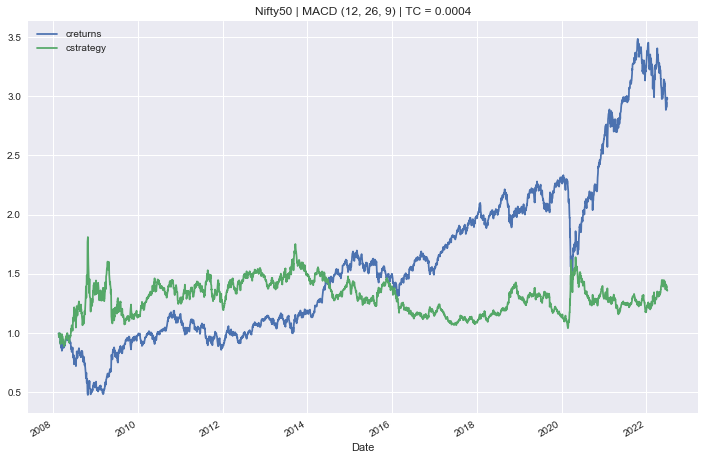

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([15., 38., 13.]), 4.189838)

In [9]:
tester.test_strategy()

(4.189838, 0.94681)

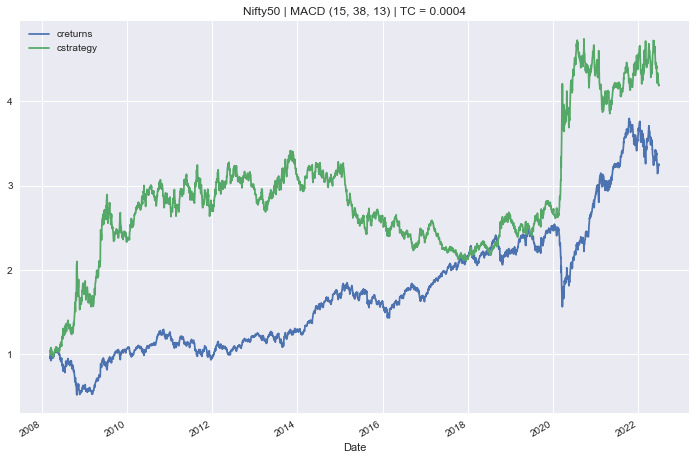

In [10]:
tester.plot_results()